In [7]:
import numpy as np
import scipy as sp
import KTCFwd
import KTCMeshing
import KTCRegularization
import KTCPlotting
import KTCScoring
import KTCAux
import matplotlib.pyplot as plt
import glob
import func
inputFolder = 'TrainingData'
outputFolder = 'Output'
categoryNbr = 1
Nel = 32
Con_Imp = 1e-6

In [8]:
fake = True
data_number = 2
mat_dict = sp.io.loadmat(inputFolder + '/ref.mat') #load the reference data
mat_files = glob.glob(inputFolder + '/data*.mat') # load the real data
mat_dict2 = sp.io.loadmat(mat_files[data_number-1])
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Inj = mat_dict2["Inj"]
Uel = mat_dict2["Uel"]

Mpat = mat_dict2["Mpat"]
Mpat = mat_dict["Mpat"] #voltage measurement pattern
z = Con_Imp * np.ones((Nel, 1))  # contact impedances
Mesh, Mesh2, vincl = func.SetupMesh(categoryNbr, Nel, inputFolder)

if fake:
    Path = 'GroundTruths/true' + str(data_number) + '.mat'
    Uel = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(0.8,0.5,1.2))
    Uelref = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(0.8,0.8,0.8))

Begin the reconstruction

[[ 0.00072002]
 [ 0.00055386]
 [ 0.00036714]
 ...
 [-0.00771814]
 [-0.00518844]
 [-0.00319465]]


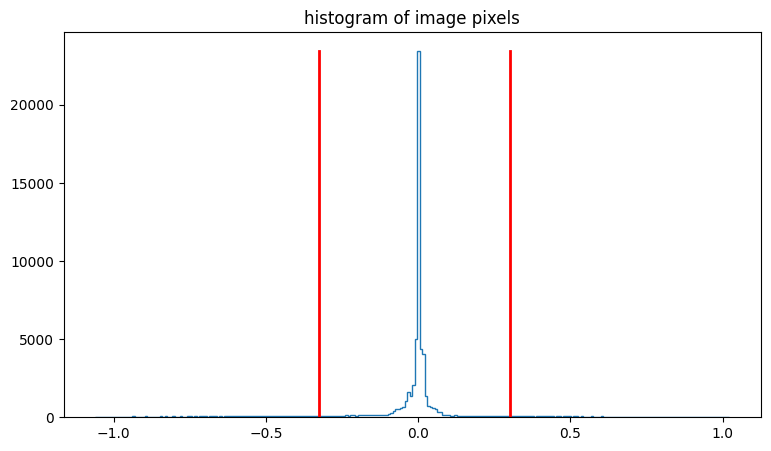

In [9]:
N_iter = 2
sigma0 = np.ones((len(Mesh.g), 1)) #linearization point
sigma0_init = sigma0
corrlength = 1 * 0.115 #used in the prior
var_sigma = 0.05 ** 2 #prior variance
mean_sigma = sigma0
smprior = KTCRegularization.SMPrior(Mesh.g, corrlength, var_sigma, mean_sigma)

# set up the forward solver for inversion
solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)

vincl = vincl.T.flatten()
# set up the noise model for inversion
noise_std1 = 0.05;  # standard deviation for first noise component (relative to each voltage measurement)
noise_std2 = 0.01;  # standard deviation for second noise component (relative to the largest voltage measurement)
solver.SetInvGamma(noise_std1, noise_std2, Uelref)

# Compute the difference of the measured real vs measured reference data
deltaU = Uel - Uelref
print(deltaU)
mask = np.array(vincl, bool) # Mask the removed electrodes

for i in range(0,N_iter):
    Usim = solver.SolveForward(sigma0, z) #forward solution at the linearization point
    J = solver.Jacobian(sigma0, z)
    deltareco = np.linalg.solve(J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ J + smprior.L.T @ smprior.L,J.T @ solver.InvGamma_n[np.ix_(mask,mask)] @ deltaU[vincl])
    #deltareco = np.linalg.solve(J.T @ J + smprior.L.T @ smprior.L,J.T @ deltaU[vincl])
    sigma0 = sigma0 + deltareco

deltareco = sigma0 - sigma0_init

deltareco_pixgrid = KTCAux.interpolateRecoToPixGrid(deltareco, Mesh) # Interpolate to picture
level, x = KTCScoring.Otsu2(deltareco_pixgrid.flatten(), 256, 7) # threshold the image histogram using Otsu's method
deltareco_pixgrid_segmented = np.zeros_like(deltareco_pixgrid)

(-0.5, 255.5, 255.5, -0.5)

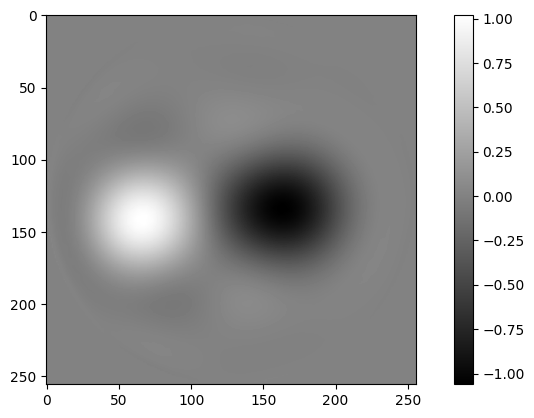

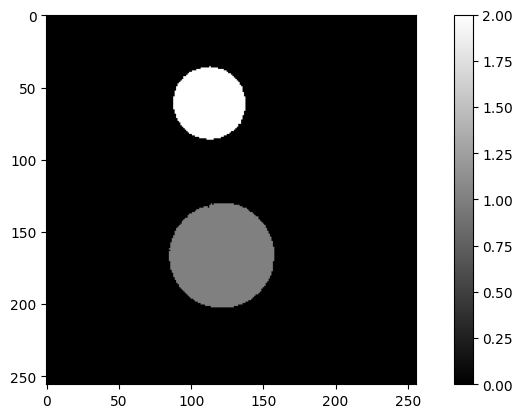

In [6]:
ind0 = deltareco_pixgrid < x[level[0]]
ind1 = np.logical_and(deltareco_pixgrid >= x[level[0]],deltareco_pixgrid <= x[level[1]])
ind2 = deltareco_pixgrid > x[level[1]]
inds = [np.count_nonzero(ind0),np.count_nonzero(ind1),np.count_nonzero(ind2)]
bgclass = inds.index(max(inds)) #background class

match bgclass:
    case 0:
        deltareco_pixgrid_segmented[ind1] = 2
        deltareco_pixgrid_segmented[ind2] = 2
    case 1:
        deltareco_pixgrid_segmented[ind0] = 1
        deltareco_pixgrid_segmented[ind2] = 2
    case 2:
        deltareco_pixgrid_segmented[ind0] = 1
        deltareco_pixgrid_segmented[ind1] = 1

reconstruction = deltareco_pixgrid_segmented
mdic = {"reconstruction": reconstruction}
fig, ax = plt.subplots()
cax = ax.imshow(deltareco_pixgrid, cmap='gray')
plt.colorbar(cax)
plt.axis('image')

truth = sp.io.loadmat('GroundTruths/true' + str(data_number) + '.mat')
truth = truth["truth"]
fig, ax = plt.subplots()
cax = ax.imshow(truth, cmap='gray')
plt.colorbar(cax)
plt.axis('image')


